In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os

### SIS Model 

#### Node-Level Equations

For a node \( i \) at time \( t \):

- **Susceptible (S):**
$$
\frac{dS_i(t)}{dt} = \mu I_i(t) - \beta S_i(t) \sum_{j \in N_i} I_j(t)
$$

- **Infected (I):**
$$
\frac{dI_i(t)}{dt} = \beta S_i(t) \sum_{j \in N_i} I_j(t) - \mu I_i(t)
$$

Where:
- $ S_i(t) $: Probability node $ i $ is susceptible at time $ t $.
- $ I_i(t) $: Probability node $ i $ is infected at time $ t $.
- $ \beta $ (beta): Infection rate.
- $ \mu $ (mu): Recovery rate.
- $ N_i $: Set of neighbors of node $ i $.

In [2]:
def sis_step(G, states, beta=0.3, mu=0.1, dt=0.1):

    new_states = states.copy()
    for node in G.nodes():
        # Get sum of infected neighbors
        infected_neighbor_sum = sum(states[n] for n in G.neighbors(node))
        
        S = 1 - states[node]  # Susceptible probability 
        I = states[node]      # Infected probability

        dI = beta * S * infected_neighbor_sum - mu * I
        new_states[node] = I + dt * dI
        
        # # Euler's method: y(t+dt) = y(t) + dt * dy/dt
        # if states[node] == 1:  # Node is infected (I)
        #     dI = beta * S * infected_neighbor_sum - mu * I
        #     new_states[node] = I + dt * dI
        # else:  # Node is susceptible (S)
        #     dS = mu * I - beta * S * infected_neighbor_sum
        #     new_prob_infected = 1 - (S + dt * dS)  # Convert dS to probability of infection
        #     new_states[node] = new_prob_infected
            
        # Ensure values stay between 0 and 1
        new_states[node] = max(0, min(1, new_states[node]))
        
        # # Convert to binary state (0 or 1) based on probability
        # new_states[node] = 1 if np.random.rand() < new_states[node] else 0
            
    return new_states

In [3]:
def plot_network_state(G, states, ax, step):
    """Plot the network state at a given time step."""
    ax.set_title(f"Step {step}")
    nx.draw(G, pos=nx.spring_layout(G, seed=42), with_labels=False, 
            node_color=['red' if states[node] == 1 else 'blue' for node in G.nodes()], 
            node_size=100,
            ax=ax)

In [4]:
def visualize_graphs(G, states_list, network_name, max_plots=100):

    """Visualize network states at different time steps."""
    num_steps = min(len(states_list), max_plots)
    num_cols = min(5, num_steps)
    num_rows = (num_steps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 3.5))
    axes = np.atleast_1d(axes).flatten()

    for t, states in enumerate(states_list[:num_steps]):
        plot_network_state(G, states, axes[t], t+1)
    
    # Hide any empty subplots
    for ax in axes[num_steps:]:
        ax.axis('off')
    
    plt.suptitle(f"Network State Progression\n{network_name}")
    plt.tight_layout()
    
    output_path = os.path.join(OUTPUT_DIR, f'network_progression_{network_name.lower().replace(" ", "_")}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [5]:
def plot_dynamics(infected_fractions, susceptible_fractions, T, network_name, isPerturbated=False):
    """Plot dynamics of infected and susceptible node fractions."""
    
    # Prepare data for plotting
    time_steps = list(range(T+1))
    
    plt.figure(figsize=(10, 6))
    
    # Plot infected fractions
    plt.plot(time_steps, infected_fractions, color='red', label='Infected', 
             marker='.', markersize=0.5)
    
    # Plot susceptible fractions
    plt.plot(time_steps, susceptible_fractions, color='blue', label='Susceptible', 
             marker='.', markersize=0.5)
    
    plt.title(f"Epidemic Dynamics\n{network_name}")
    plt.xlabel("Time Steps")
    plt.ylabel("Fraction of Nodes")
    plt.legend(title="State", loc="best")
    plt.grid(True, linestyle='--')
    plt.tight_layout()

    if not isPerturbated: 
        # Save the figure
        output_path = os.path.join(OUTPUT_DIR, f'epidemic_dynamics_{network_name.lower().replace(" ", "_")}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        # Save the figure
        output_path = os.path.join(OUTPUT_DIR, f'epidemic_dynamics_{network_name.lower().replace(" ", "_")}_perturbated.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

In [6]:
def sis_simulation(G, N, beta, mu, T, network_name, initial_infected_fraction=0.2):
    # Set random seed for reproducibility
    # np.random.seed(42)
    
    # Initialize states
    states = {node: 0 for node in G.nodes()}
    
    # Randomly select initially infected nodes
    initial_infected = np.random.choice(
        list(G.nodes()), 
        size=max(1, int(N * initial_infected_fraction)), 
        replace=False
    )
    
    for node in initial_infected:
        states[node] = 1
    
    # Track simulation progression
    states_list = [states.copy()]
    infected_fractions = [len(initial_infected) / N]
    susceptible_fractions = [1 - infected_fractions[0]]
    
    # Select 5 random nodes to track
    tracked_nodes = np.random.choice(
        list(G.nodes()), 
        size=5, 
        replace=False
    )
    
    # Calculate distances from initially infected nodes
    node_distances = {}
    for node in tracked_nodes:
        # Find minimum distance to any initially infected node
        min_distance = min(
            nx.shortest_path_length(G, source=infected_node, target=node) 
            for infected_node in initial_infected
        )
        node_distances[node] = min_distance

        # Calculate distances from initially infected nodes
    all_node_distances = {}
    for node in G.nodes():
        # Find minimum distance to any initially infected node
        min_distance = min(
            nx.shortest_path_length(G, source=infected_node, target=node) 
            for infected_node in initial_infected
        )
        all_node_distances[node] = min_distance
    
    # Initialize tracking for selected nodes
    tracked_nodes_states = {node: [states[node]] for node in tracked_nodes}

    print(f"Step : 1/{T}", end='\r')
    # Run simulation
    for _ in range(T):
        states = sis_step(G, states, beta, mu)
        states_list.append(states.copy())
        print(f"Step {_}/{T}", end='\r', flush=True)
        
        # Update tracked nodes' states
        for node in tracked_nodes:
            tracked_nodes_states[node].append(states[node])
        
        # infected = sum(states.values())
        # infected_fractions.append(infected / N)
        # susceptible_fractions.append(1 - infected_fractions[-1])

    
    # Visualize results
    # visualize_graphs(G, states_list, network_name)
    # plot_dynamics(infected_fractions, susceptible_fractions, T, network_name)
    
    # Prepare and return results
    results = {
        'tracked_nodes': tracked_nodes,
        'node_distances': node_distances,
        'tracked_nodes_states': tracked_nodes_states
    }
    
    return states,results, all_node_distances

def plot_tracked_nodes_states(results, T, network_name):
    plt.figure(figsize=(10, 6))
    
    # Create a color palette for the lines
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    # Plot each tracked node's state over time
    for i, (node, states) in enumerate(results['tracked_nodes_states'].items()):
        plt.plot(range(T+1), states, 
                 label=f'Node {node} (Dist: {results["node_distances"][node]})', 
                 color=colors[i],
                 linewidth=2)
        plt.title(f'Node States Over Time - {network_name} Network')
        plt.xlabel('Time Steps')
        plt.ylabel('Node State (0: Susceptible, 1: Infected)')
        plt.yticks([0, 1])
        plt.legend(title='Nodes (Initial Distance to an Infected Node)', loc='best')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        output_path = os.path.join('images', f'time_signals_{node}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
    # plt.tight_layout()
    # plt.show()
    # output_path = os.path.join(OUTPUT_DIR, f'epidemic_dynamics_{network_name.lower().replace(" ", "_")}.png')
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Note: This assumes you have previously defined sis_step(), visualize_graphs(), and plot_dynamics() functions

In [7]:
def modified_sis_step_perturbed(G, states, beta, mu, perturb_node, delta_i):
    new_states = sis_step(G, states, beta, mu)
    # Force perturbed node to maintain its increased infection state
    new_states[perturb_node] = min(1, states[perturb_node] + delta_i)
    return new_states


def perturb_system(G, initial_states, tracked_nodes, N, beta, mu, T, network_name, perturb_node, delta_i=0.2):
    states = initial_states.copy()
    
    # Track simulation progression
    states_list = [states.copy()]
    infected_fractions = [sum(states.values()) / N]
    susceptible_fractions = [1 - infected_fractions[0]]
    
    # Initialize tracking for selected nodes
    tracked_nodes_states = {node: [states[node]] for node in tracked_nodes}
    
    # Run simulation with perturbation
    for _ in range(T):
        states = modified_sis_step_perturbed(G, states, beta, mu, perturb_node, delta_i)
        states_list.append(states.copy())
        
        # Update tracked nodes' states
        for node in tracked_nodes:
            tracked_nodes_states[node].append(states[node])
        
        infected = sum(states.values())
        infected_fractions.append(infected / N)
        susceptible_fractions.append(1 - infected_fractions[-1])
    
    # Plot overall dynamics
    network_name_modified = f"{network_name} (Perturbed Node {perturb_node})"
    # plot_dynamics(infected_fractions, susceptible_fractions, T, network_name_modified)
    
    return {
        'states_list': states_list,
        'infected_fractions': infected_fractions,
        'susceptible_fractions': susceptible_fractions,
        'tracked_nodes_states': tracked_nodes_states
    }

Running simulation for Scale-Free Graph (before perturbation)
Time Signals (before perturbation)


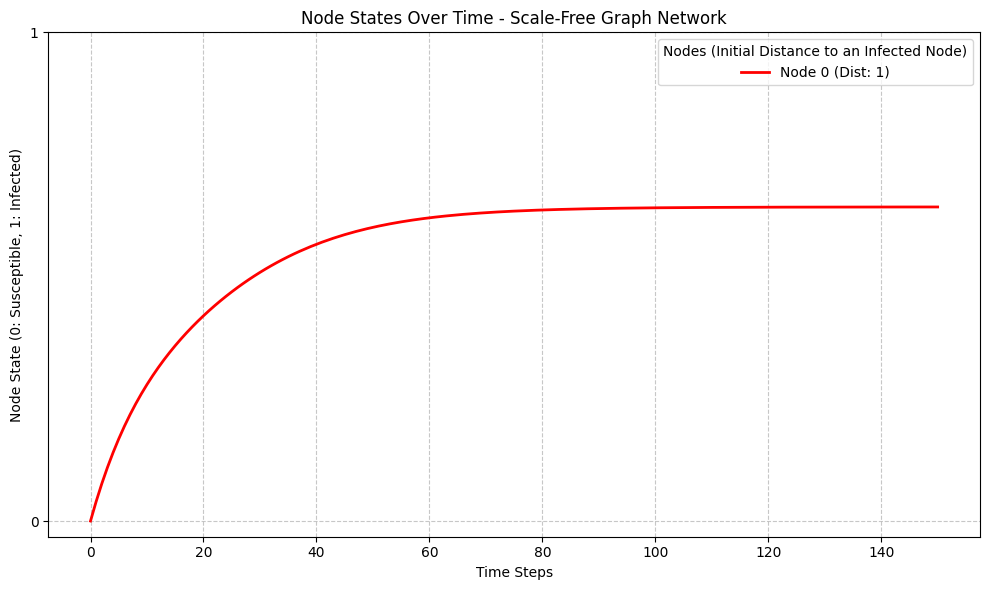

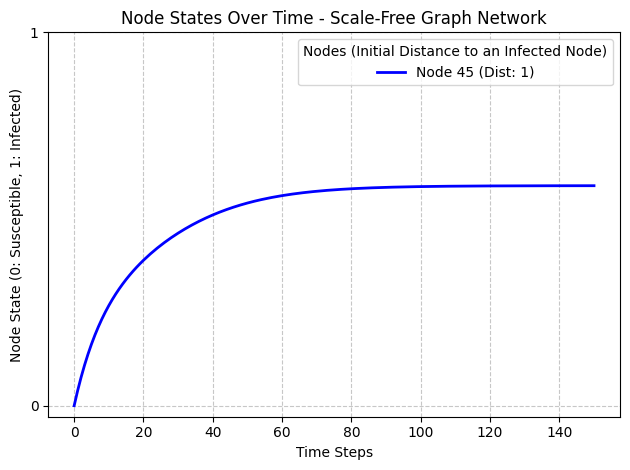

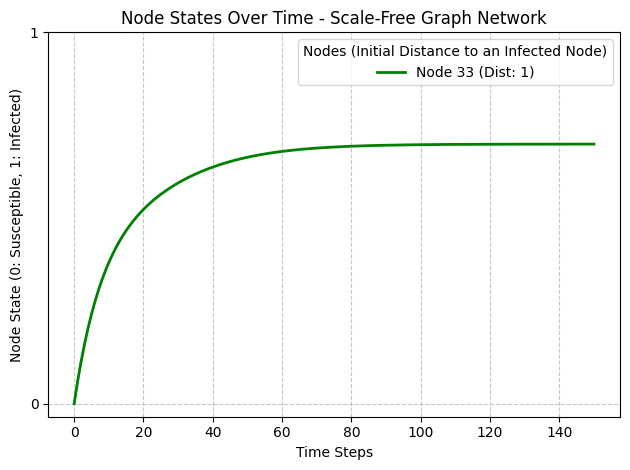

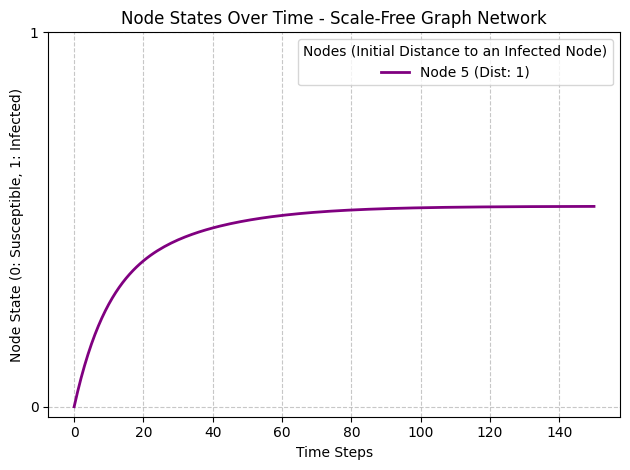

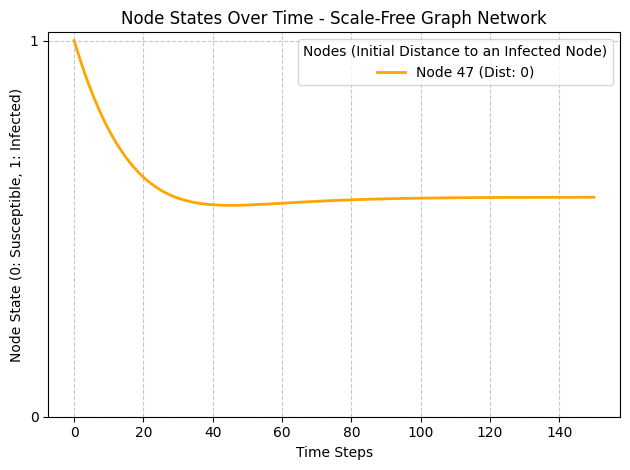

In [8]:
OUTPUT_DIR = 'images'
os.makedirs(OUTPUT_DIR, exist_ok=True)
"""Run SIS simulations on different network types."""
# np.random.seed(42)
# Simulation parameters
params = {
    'N': 50,      # Number of nodes
    'beta': 0.2,  # Infection rate
    'mu': 0.3,    # Recovery rate
    'T':  150    # Time steps
}

# Network to simulate
name = 'Scale-Free Graph'
# Change to Erdős-Rényi graph
G = nx.erdos_renyi_graph(params['N'], p=0.1)
# Run the Simulation for before and after perturbation
print(f"Running simulation for {name} (before perturbation)")
states,results, all_node_distances = sis_simulation(G, **params, network_name=name)

tracked_nodes = list(results['tracked_nodes'])
# print(tracked_nodes)

print("Time Signals (before perturbation)")
plot_tracked_nodes_states(results, params['T'], name)


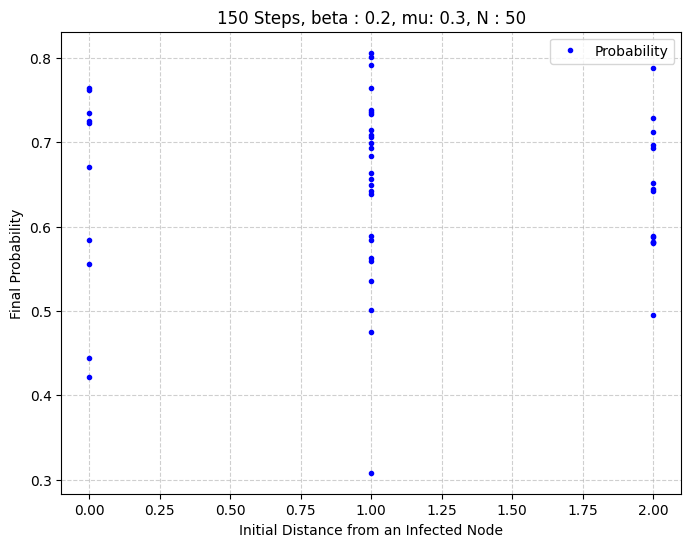

In [9]:

plt.figure(figsize=(8, 6))
plt.plot(list(all_node_distances.values()), list(states.values()), '.', color='b', label='Probability')
plt.title(f"{params['T']} Steps, beta : {params['beta']}, mu: {params['mu']}, N : {params['N']}")
plt.xlabel("Initial Distance from an Infected Node")
plt.ylabel("Final Probability")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [10]:
print(f"Running perturbation experiment for {name}")
#  # Choose a node to perturb (randomly)
perturb_node = np.random.choice(list(G.nodes()))

# # Run perturbation experiment
perturb_results = perturb_system(G,states,**params, network_name=name, perturb_node=perturb_node, tracked_nodes=tracked_nodes)

after_perb_time_signals = {
        'tracked_nodes': tracked_nodes,
        'node_distances': results['node_distances'],
        'tracked_nodes_states': perturb_results['tracked_nodes_states']
    }

Running perturbation experiment for Scale-Free Graph


Time Signals (before perturbation)


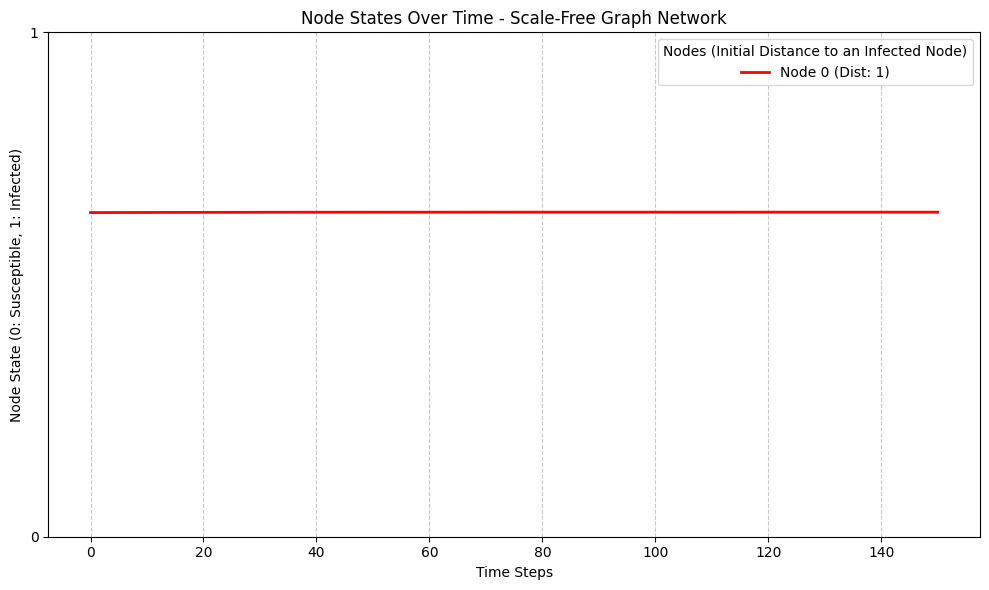

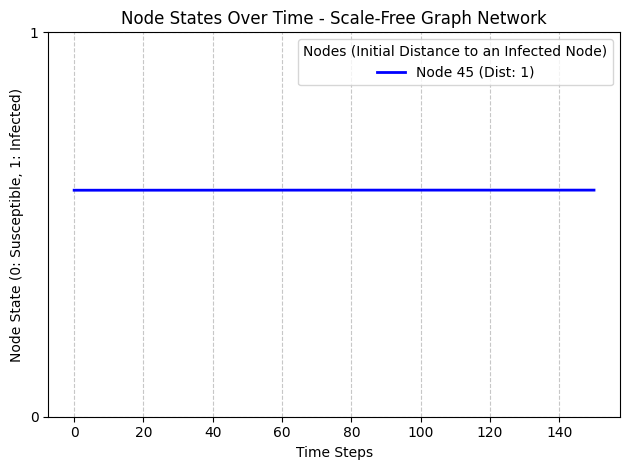

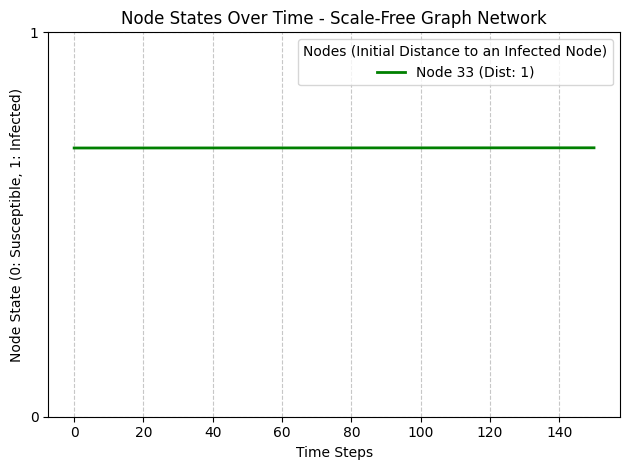

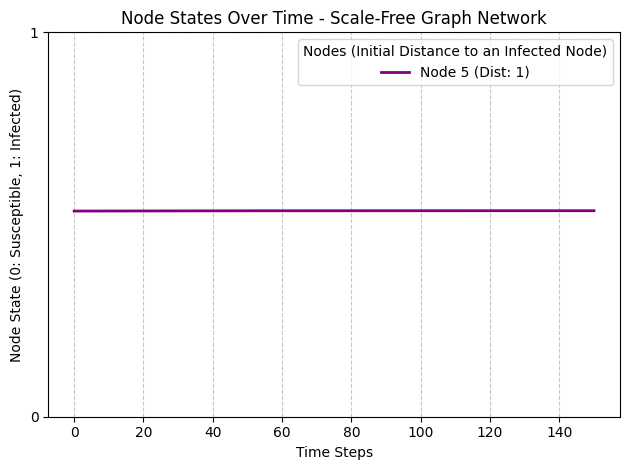

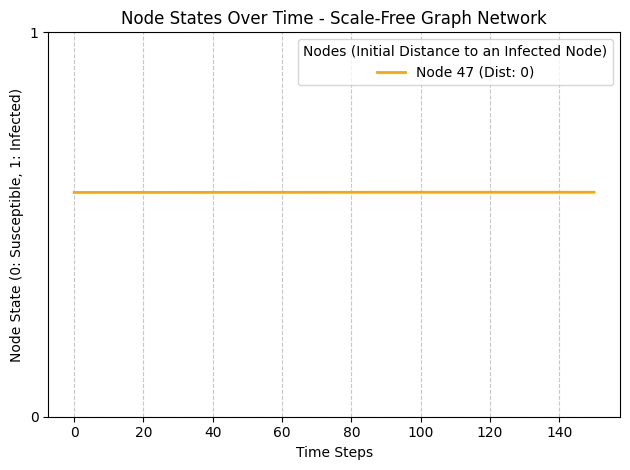

In [11]:
print("Time Signals (before perturbation)")
plot_tracked_nodes_states(after_perb_time_signals, params['T'], name)